In [1]:
from conv_detector  import ConvDetector
from generators import BDIGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import Mean, MeanIoU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

In [3]:
ConvDetector_net = ConvDetector(input_sh=(128, 128, 3), dp_rate=0.45)
ConvDetector_net.compile(optimizer=Adam(), 
                    loss_fn=[
                        MeanSquaredError(), 
                        MeanSquaredError(), 
                        BinaryCrossentropy()
    ])
    
generator = BDIGenerator(input_sh=(128, 128, 3))
images = []
bb = []
bba = []
cll_labels = []
for (sample_n, sample) in enumerate(iter(generator)):

    if sample_n == 1000:
        break

    images.append(sample[0])
    bb.append(sample[1])
    bba.append(sample[2])
    cll_labels.append(sample[3])
    
images = np.asarray(images)
bb = np.asarray(bb)
bba = np.asarray(bba)
cll_labels = np.asarray(cll_labels)

    

images = images / 255.0
images = (images - np.mean(images)) / np.std(images)
bba = (bba - np.mean(bba)) / np.std(bba)

# ConvDetector_net.fit(images, (bb, bba, cll_labels),
#            epochs=1, batch_size=32) 
     
# ConvDetector_net.save_weights(filepath="c:\\Users\\1\\Desktop\\drone_solution_meta\\models_weights\\yolo_weights.weights.h5")
ConvDetector_net.load_weights(filepath="c:\\Users\\1\\Desktop\\drone_solution_meta\\models_weights\\yolo_weights.weights.h5")
pred_boxes, pred_logits = ConvDetector_net.predict(images)

C:\Users\1\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 717ms/step


In [4]:
from inference_test import grads_inference
print(ConvDetector_net.grad_model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 32,    │    113,184 │ input_layer[0][0] │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_conv_layer     │ (None, 32, 32,    │      9,248 │ sequential[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 12)        │  2,099,692 │ last_conv_layer[… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 1)         │         13 │ sequential_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,222,137 (8.48 MB)

 Trainable params: 2,222,137 (8.48 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# random_idx = np.random.randint(0, images.shape[0], 3)
# images_batch = images[random_idx]
# test_heatmaps = grads_inference(inputs=images_batch, model=ConvDetector_net.grad_model)

In [6]:
pred_boxes = pred_boxes.astype("int")
print(pred_boxes[56])

[252 149 121 110]


In [7]:
generator = BDIGenerator(input_sh=None)
images = []
bb = []
bba = []
cll_labels = []
for (sample_n, sample) in enumerate(iter(generator)):

    if sample_n == 1000:
        break

    images.append(sample[0])
    bb.append(sample[1])
    bba.append(sample[2])
    cll_labels.append(sample[3])
    
images = np.asarray(images)
bb = np.asarray(bb)
bba = np.asarray(bba)
cll_labels = np.asarray(cll_labels)

In [8]:
bb = bb.astype("int")

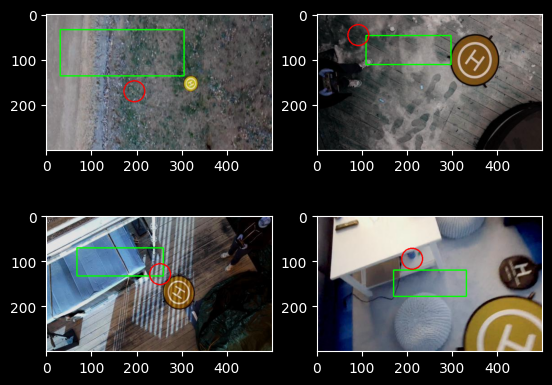

In [9]:
plt.style.use("dark_background")
fig, axis = plt.subplots(nrows=2, ncols=2)

for i in range(axis.shape[0]):
    for j in range(axis.shape[1]):

        
        random_idx = np.random.randint(0, images.shape[0])
        image_sample = images[random_idx]
        image_sample = cv2.rectangle(image_sample, bb[random_idx][:2], bb[random_idx][2:], color=(0, 255, 0), thickness=2)
        image_sample = cv2.circle(image_sample, pred_boxes[random_idx][:2], 23, color=(255, 0, 0), thickness=2)
        
        axis[i, j].imshow(image_sample)

plt.show()

In [43]:
random_idx = np.random.randint(0, images.shape[0])
image_sample = images[random_idx]
res_sample = cv2.resize(image_sample, (128, 128))
res_sample = np.expand_dims(res_sample, axis=0)

pred_box, pred_logit = ConvDetector_net.predict(res_sample)
pred_box = pred_box[0].astype("int")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


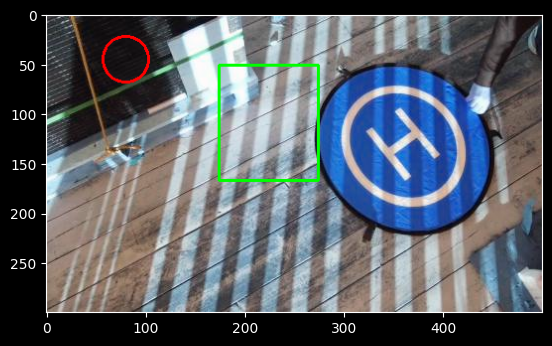

In [44]:
fig, axis = plt.subplots()
image_sample = cv2.rectangle(image_sample, bb[random_idx][:2], bb[random_idx][2:], color=(0, 255, 0), thickness=2)
image_sample = cv2.circle(image_sample, pred_box[:2], 23, color=(255, 0, 0), thickness=2)
axis.imshow(image_sample)

In [36]:
random_image_batch = np.random.randint(0, images.shape[0], 100)
images_batch = images[random_image_batch]
